# Plotting Tools
Some basic plotting tools used throughout the notebook.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Plot 2 images side-by-side
def plot_sbs(img1, img2, cmap1 = 'brg', cmap2 = 'brg'):
    
    plt.figure(figsize = (16, 20))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap1)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap2)

    
def plot_imgs(X, title=[], cols = 2, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    plotNum = 1
    plt.figure(figsize = (16, num_rows*4))
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(X[i], cmap=cmap)
        if(title):
            plt.title(title[i])
        plotNum = plotNum + 1

# Extract Sample Images from Challenge Video
Here, I'll grab some images for use throughout this notebook.

In [2]:
from moviepy.editor import VideoFileClip

# Times for frames to extract
times = np.arange(0,50,5)

clip1 = VideoFileClip("project_video.mp4")

raw_imgs = []

for time in times:
    raw_imgs.append(clip1.get_frame(time))
    

# Camera Calibration

In [3]:
import glob

# Read in images
cal_files = glob.glob('camera_cal/*.jpg')

cal_imgs = []
for file in cal_files:
    cal_imgs.append(mpimg.imread(file)) #RGB image
    
"""
for img in cal_imgs:
    plt.figure()
    plt.imshow(img)
"""

'\nfor img in cal_imgs:\n    plt.figure()\n    plt.imshow(img)\n'

In [4]:
import cv2
import pickle

def cal_camera(imgs, nc = (9,6), plots = False):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nc[0]*nc[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:nc[0], 0:nc[1]].T.reshape(-1,2)
    
    shape = imgs[0].shape[1::-1]
    
    for img in imgs:
        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, nc, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #img = cv2.drawChessboardCorners(img, nc, corners, ret)
            #plt.figure()
            #plt.imshow(img)
    
    retval, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    return matrix, distortion



save_mtx = 'camera_cal/cam_cal_mtx.p'
save_dist = 'camera_cal/cam_cal_dist.p'

action = 'gen'

if(action == 'gen'):
    UNDIST_MTRX, UNDIST_DIST = cal_camera(cal_imgs)
    pickle.dump(UNDIST_MTRX, open(save_mtx, "wb" ))
    pickle.dump(UNDIST_DIST, open(save_dist, "wb" ))
elif(action == 'load'):
    with open(save_mtx, mode='rb') as f:
        mtx = pickle.load(f)
    with open(save_dist, mode='rb') as f:
        dist = pickle.load(f)
else:
    print("Choose whether to generate or load camera calibration data.")
    

# Undistort Images


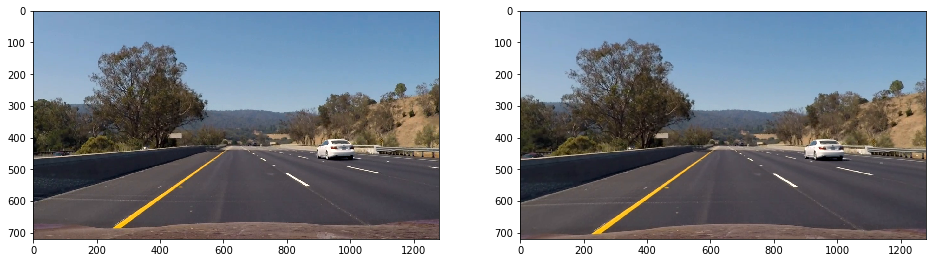

In [5]:
# Undistort an image

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undist_imgs = []

for img in raw_imgs:
    undist_imgs.append(undistort(img, UNDIST_MTRX, UNDIST_DIST))

plot_sbs(raw_imgs[4], undist_imgs[4])

# Thresholding

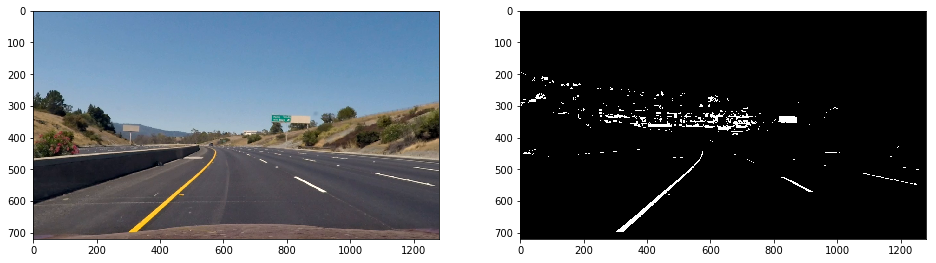

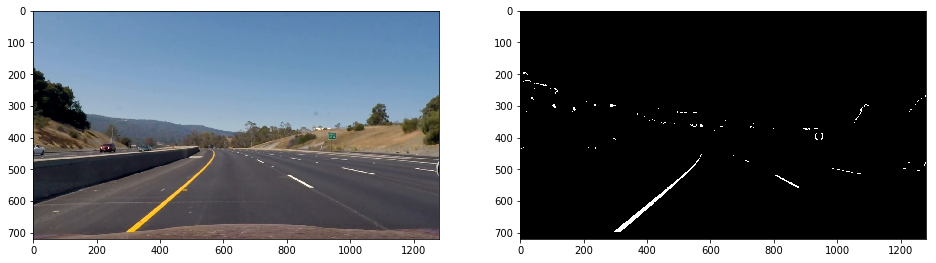

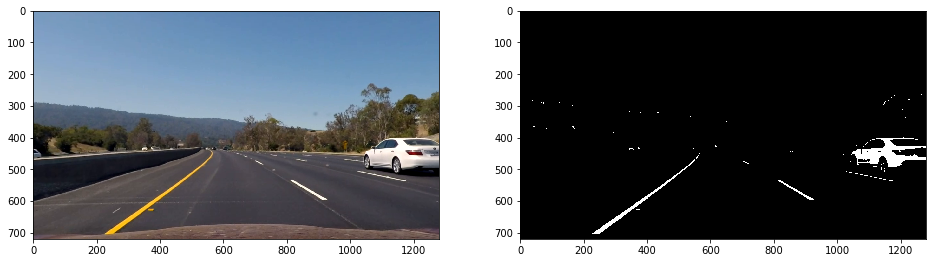

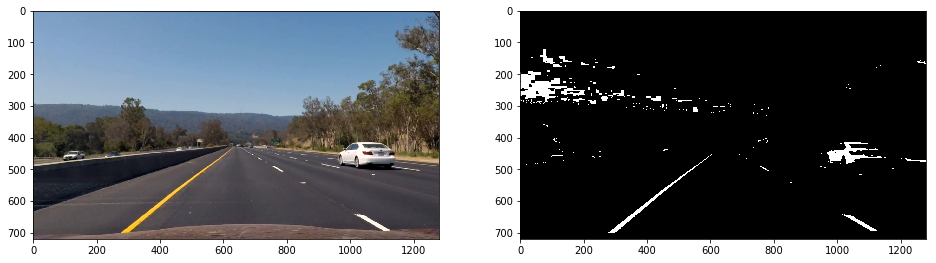

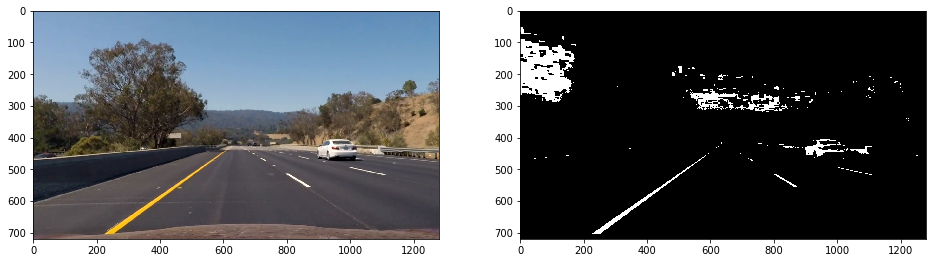

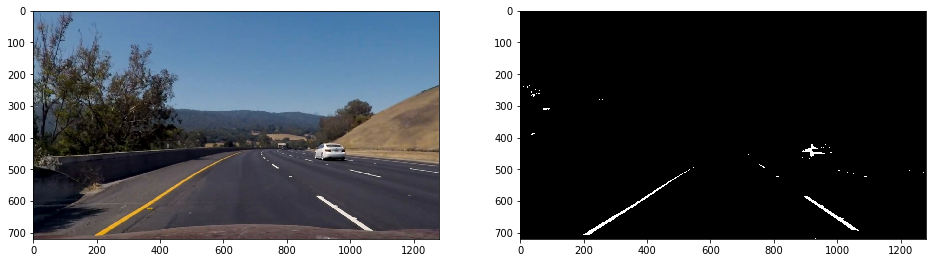

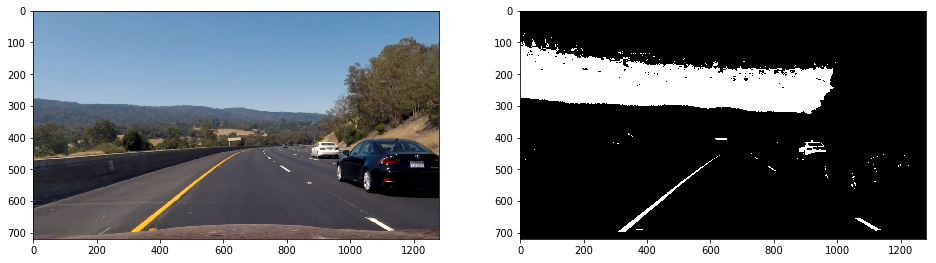

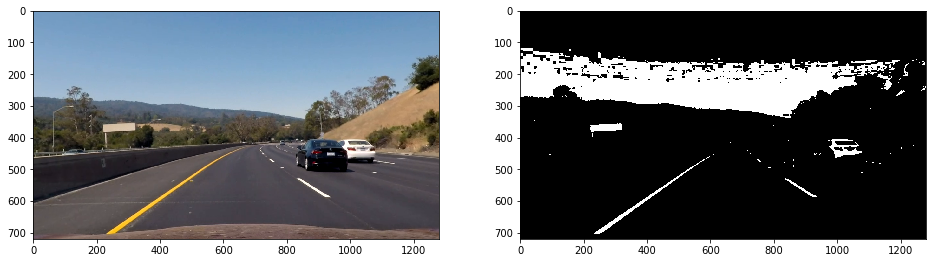

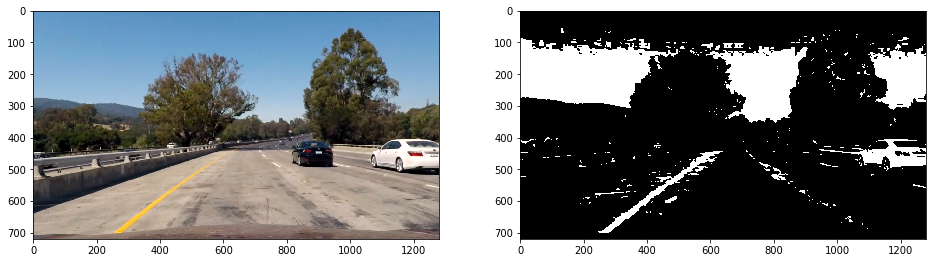

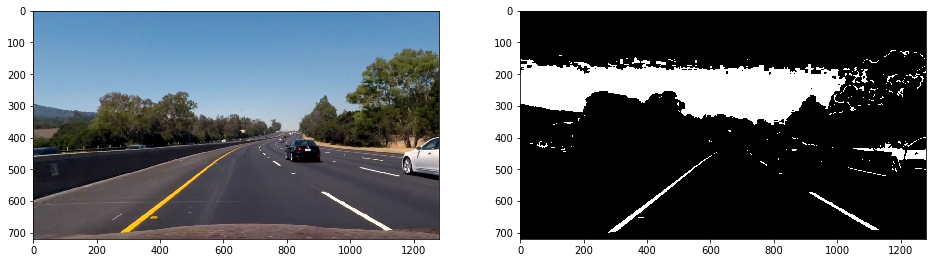

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, color1_lower, color1_upper, color2_lower, color2_upper):
    """ Applies an HSV color transform, and performs color selection of two colors
    Color selection was performed in the HSV color space, since it's much easier to pick
    out individual colors than in RGB space
    """
    #Convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Generate masks
    mask2 = cv2.inRange(hsv, color2_lower, color2_upper)
    mask1 = cv2.inRange(hsv, color1_lower, color1_upper)
    
    
    # Apply mask to original image
    mask = cv2.bitwise_or(mask1, mask2)
    
    binary_output = np.zeros_like(mask).astype(np.uint8)
    binary_output[mask>0] = 1; # convert to 0-1
    
    return binary_output


def red_select(img, thresh=(0,255)):
    red = img[:,:,0]
    binary_output = np.zeros_like(red)
    binary_output[(red > thresh[0]) & (red <= thresh[1])] = 1
    return binary_output


def thresh_fcn(img, ksize=5, xythresh=(20,100), magthresh=(10,100), 
               dirthresh=(0.6, 1.0), redthresh=(170,255), hlsthresh=(80,255), plot = False):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xythresh)
    if False:
        plt.figure()
        plt.imshow(gradx, cmap='gray')
        plt.title('X Grad')
    
    """
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=xythresh)
    plt.figure()
    plt.imshow(grady, cmap='gray')
    plt.title('Y Grad')
    """
    # Define yellow and white colors for used in color selection
    lower_yellow = np.array([40, 40, 40])
    upper_yellow = np.array([70, 255, 255])
    lower_white = np.array([0, 0, 205])
    upper_white = np.array([255, 255, 255])
    
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    if False:
        plt.figure()
        plt.imshow(mag_binary, cmap='gray')
        plt.title('Grad Magnitude')
    
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=dirthresh)
    if False:
        plt.figure()
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Grad Dir')
    
    red_binary = red_select(img, thresh=redthresh)
    if plot:
        plt.figure()
        plt.imshow(red_binary, cmap='gray')
        plt.title('Red')
    
    hls_binary = hls_select(img, thresh=hlsthresh)
    if plot:
        plt.figure()
        plt.imshow(hls_binary, cmap='gray')
        plt.title('HLS')
        
        
    hsv_binary = hsv_select(img, lower_yellow, upper_yellow, lower_white, upper_white)
    if plot:
        plt.figure()
        plt.imshow(hsv_binary, cmap='gray')
        plt.title('HSV Select')

    newimg = np.zeros_like(img[:,:,0])
    #newimg[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #removed the y grad
    #newimg[((gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #Using only HLS and red
    #newimg[ (red_binary == 1) & (hls_binary == 1)] = 1
    
    newimg[(hsv_binary == 1)] = 1
    
    
    return newimg

"""
test_img = cv2.cvtColor(raw_imgs[14], cv2.COLOR_RGB2HLS)
s_channel = test_img[:,:,2]
plt.imshow(s_channel, cmap='gray')
"""

thresh_imgs = []
for i in range(len(undist_imgs)): #undist_imgs
    thresh_imgs.append(thresh_fcn(undist_imgs[i], plot=False))
    plot_sbs(undist_imgs[i], thresh_imgs[i], cmap2 = 'gray')
    
    

# Perspective Transform

In theory, any image (of the size that we're using, at least) that has been corrected for distortion could be used to determine how to warp the perspective to plot lane lines. Therefore, I'll do this with one of the provided "straight" line images, since frames with straight lines are scarce in the challenge video.

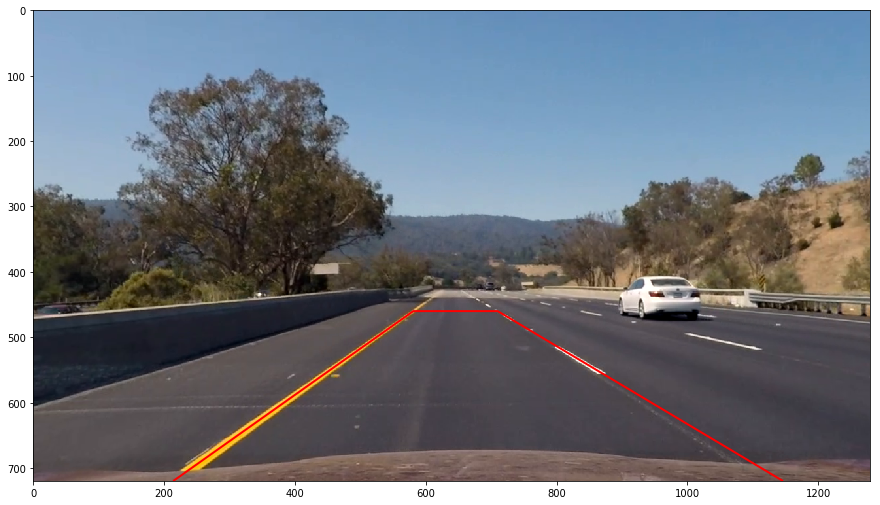

In [7]:
# Grab an image to use for calibrating the perspective warp
#strt_img = mpimg.imread('test_images/straight_lines1.jpg')
strt_img = undist_imgs[4]
shp = strt_img.shape

# Pick out some points - these were fine-tuned by hand
num = 0
xpnts = [215-num, 581-num, 710+num, 1145+num]
ypnts = [shp[0]-1, 460, 460, shp[0]-1,]

# Plot points
plt.figure(figsize = (15,25));
plt.imshow(strt_img);
plt.plot(xpnts, ypnts, 'r-', linewidth=2);


[250, 250, 1030, 1030] [720, 0, 0, 720]


(720, 0)

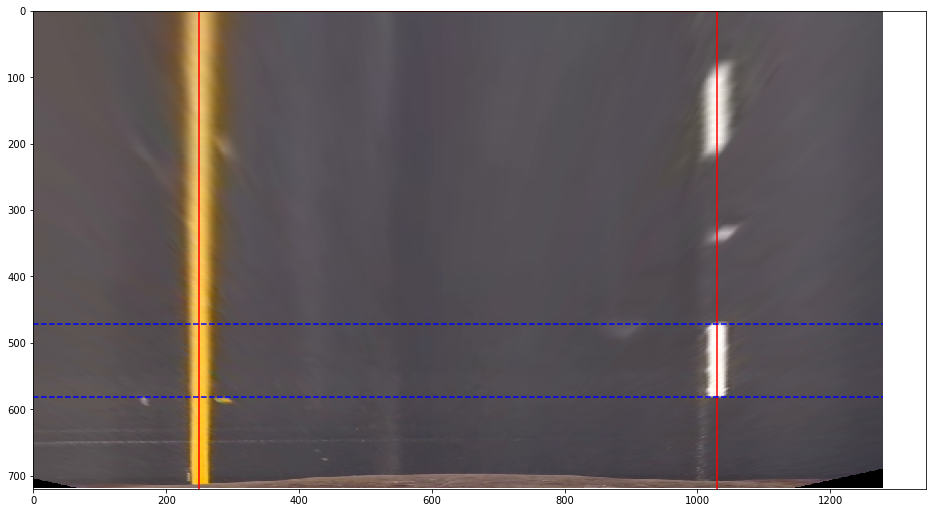

In [8]:
# Define a warping function to do the perspective transform

# Reshape to the format required by cv2
srcx = np.array(xpnts)[np.newaxis].T
srcy = np.array(ypnts)[np.newaxis].T
src = np.concatenate((srcx, srcy), axis=1).astype(np.float32)

ofst = 250

dstxpnts = [ofst, ofst, shp[1]-ofst, shp[1]-ofst]
dstypnts = [shp[0], 0, 0, shp[0]]
dstx = np.array(dstxpnts)[np.newaxis].T
dsty = np.array(dstypnts)[np.newaxis].T
dst = np.concatenate((dstx, dsty), axis=1).astype(np.float32)

# Warp
WARP_MTRX = cv2.getPerspectiveTransform(src,dst)

def warpPers(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

plt.figure(figsize=(16, 24));

print(dstxpnts, dstypnts)

warped_img = warpPers(strt_img, WARP_MTRX);
plt.imshow(warped_img);
plt.plot(dstxpnts, dstypnts, 'r-')
plt.plot((0, 1280), (472, 472), 'b--')
plt.plot((0, 1280), (582, 582), 'b--')
plt.ylim(720, 0)

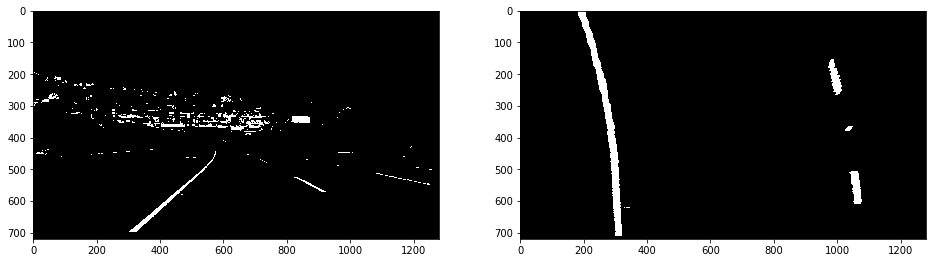

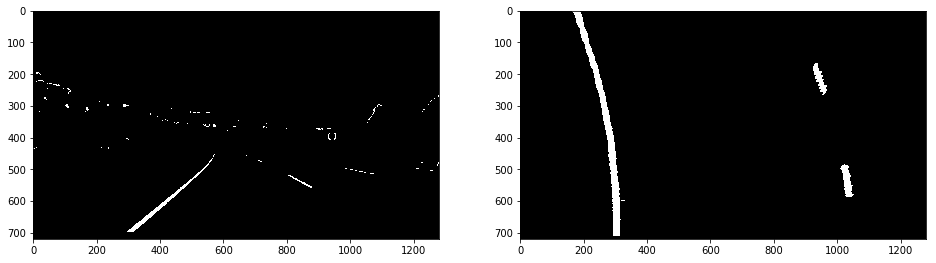

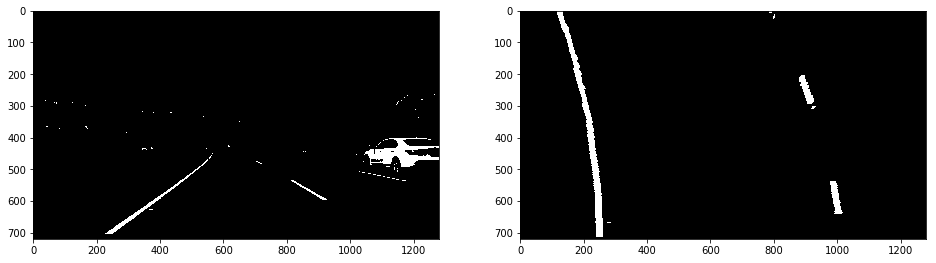

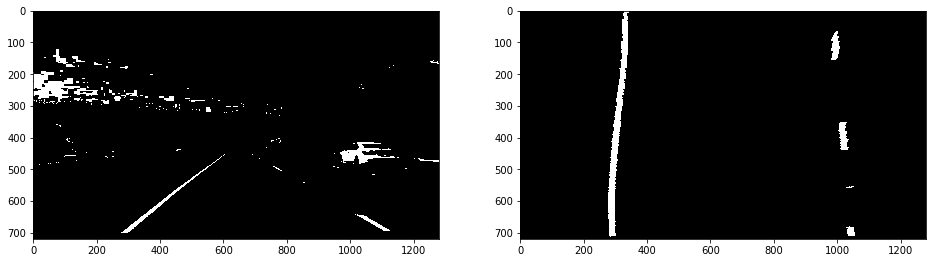

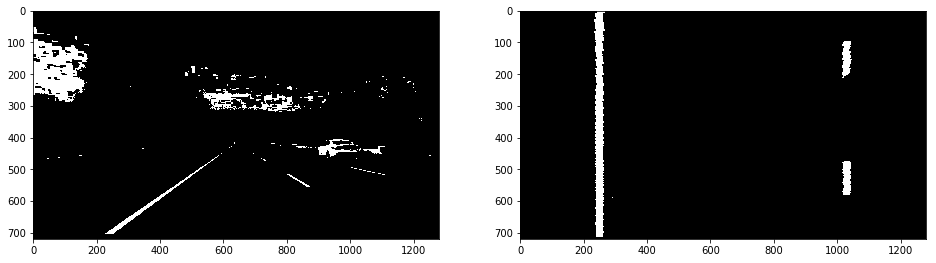

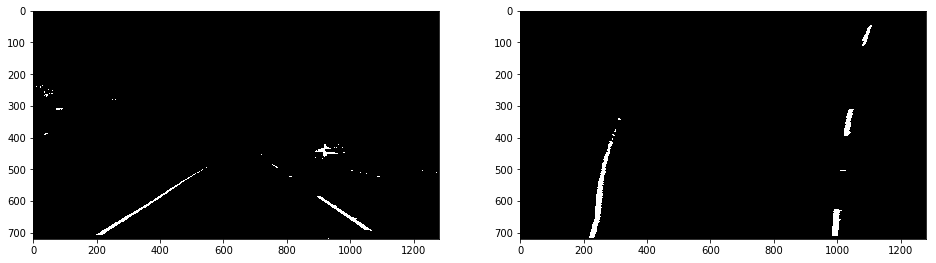

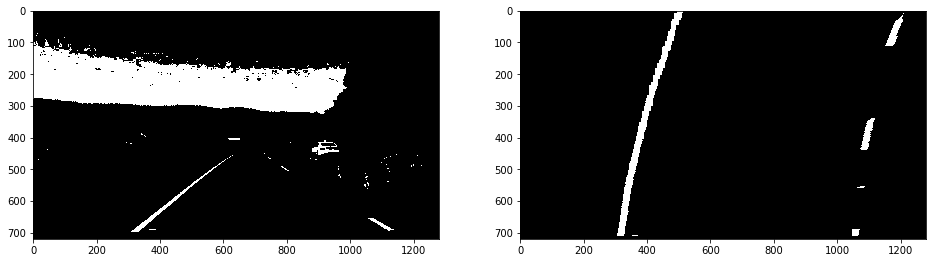

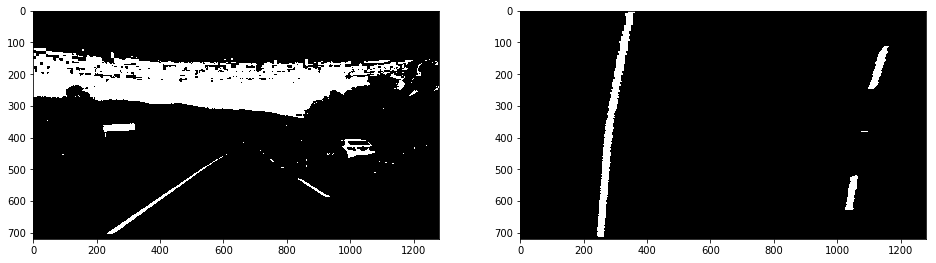

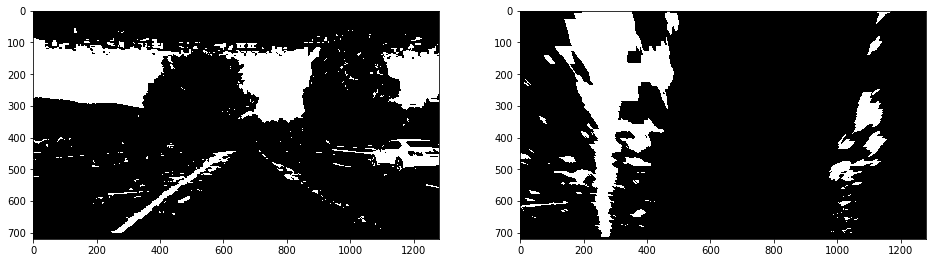

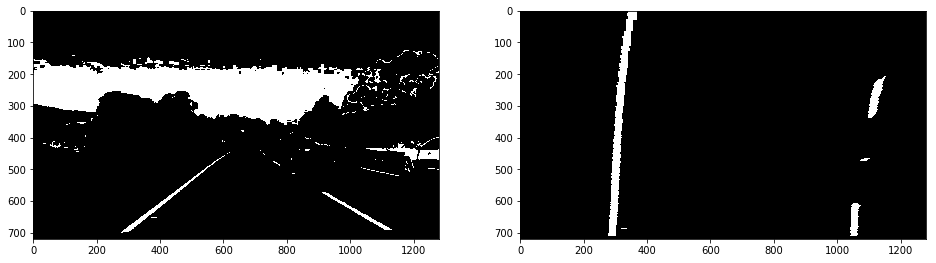

In [9]:
# Try on a few images from the video

warp_imgs = []
for img in thresh_imgs:
    warp_imgs.append(warpPers(img, WARP_MTRX))
    plot_sbs(img, warp_imgs[-1], cmap1='gray', cmap2='gray')
    


# Finding Lane Lines

In [10]:
# Define conversion from pixel space to world space - taken from measurements from sample videos
MPX = 3.7/780
MPY = 3.3/110
CURV_IDX = 150

print(MPX)

0.004743589743589744


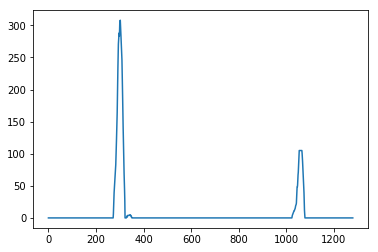

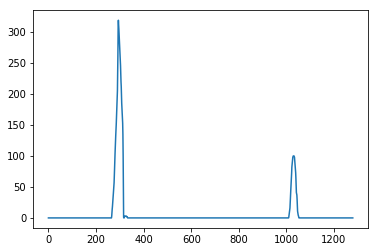

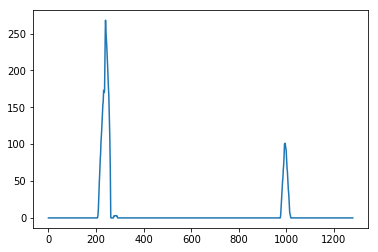

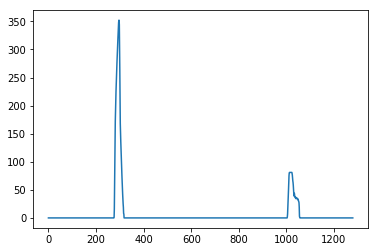

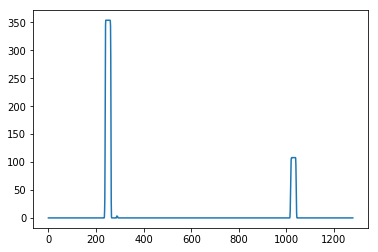

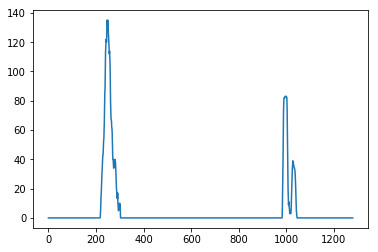

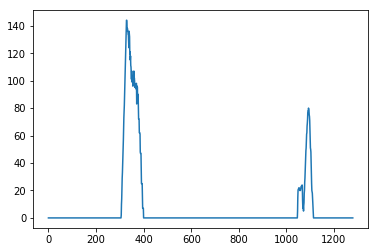

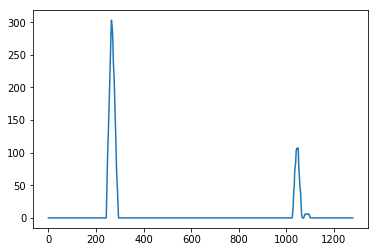

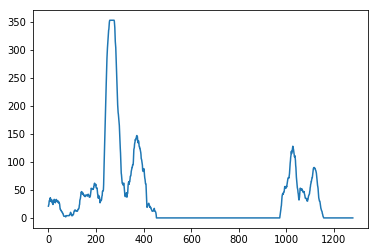

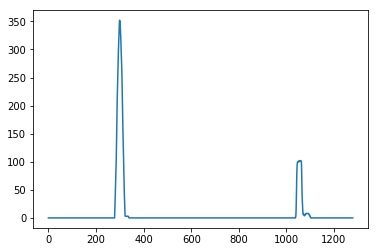

In [11]:
# Single image for some testing
test_idx = 1


def lane_hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


for img in warp_imgs:
    plt.figure()
    plt.plot(lane_hist(img))



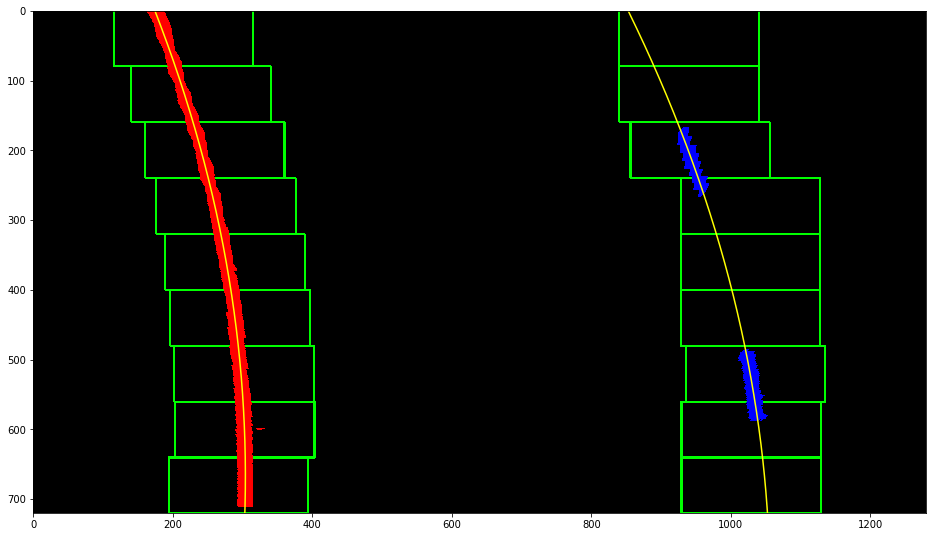

In [12]:
# This function should operate in pixel space, since it's dealing directly with images
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = lane_hist(img)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    l_windows = 0
    r_windows = 0
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            l_windows = l_windows+1
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            r_windows = r_windows+1

    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    # "confidnce" of the results -> needs some work above
    l_conf = l_windows/nwindows
    r_conf = r_windows/nwindows
    
    return leftx, lefty, l_conf, rightx, righty, r_conf, out_img


# Fit a polynomical to x and y data
def fit_polynomial(x, y):
    success = False
    fit = np.polyfit(y, x, 2)
   
    # if list are empty, we didn't get a fit
    if fit.size:
        success = True
    
    return fit, success
    
# Evaluate polynomial at given y values    
def eval_poly(fit, yvals):
    plotx = fit[0]*yvals**2 + fit[1]*yvals + fit[2]
    return plotx


def color_lines(img, x, y, color = (255,0,0)):
    img[y,x] = color
    return img

leftx, lefty, l_conf, rightx, righty, r_conf, out_img = find_lane_pixels(warp_imgs[test_idx])
left_fit, s = fit_polynomial(leftx, lefty)
right_fit, s = fit_polynomial(rightx, righty)

thisImg = warp_imgs[test_idx]
ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

# Plots the left and right polynomials on the lane lines
plt.figure(figsize = (16,20))
plt.plot(eval_poly(left_fit, ploty), ploty, color='yellow')
plt.plot(eval_poly(right_fit, ploty), ploty, color='yellow')
color_lines(out_img, leftx, lefty)
color_lines(out_img, rightx, righty, (0,0,255))
plt.imshow(out_img)


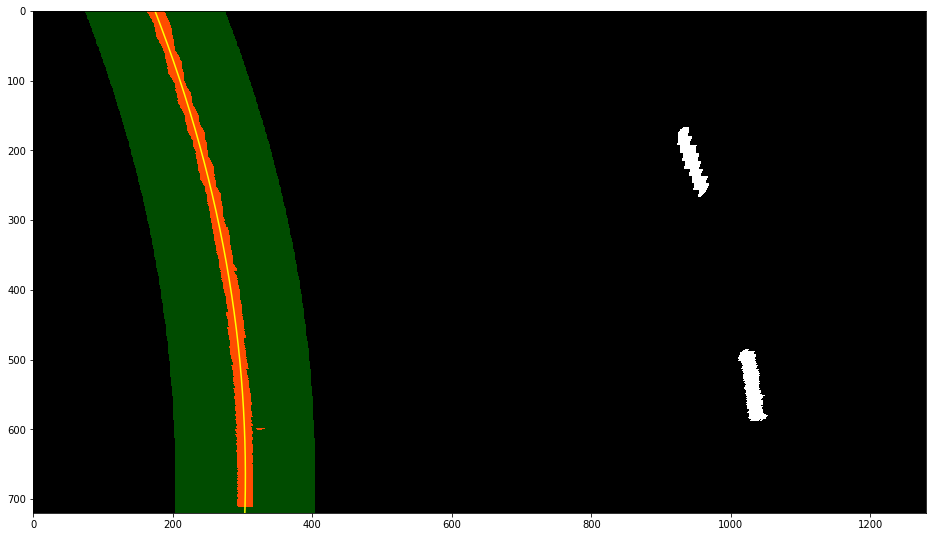

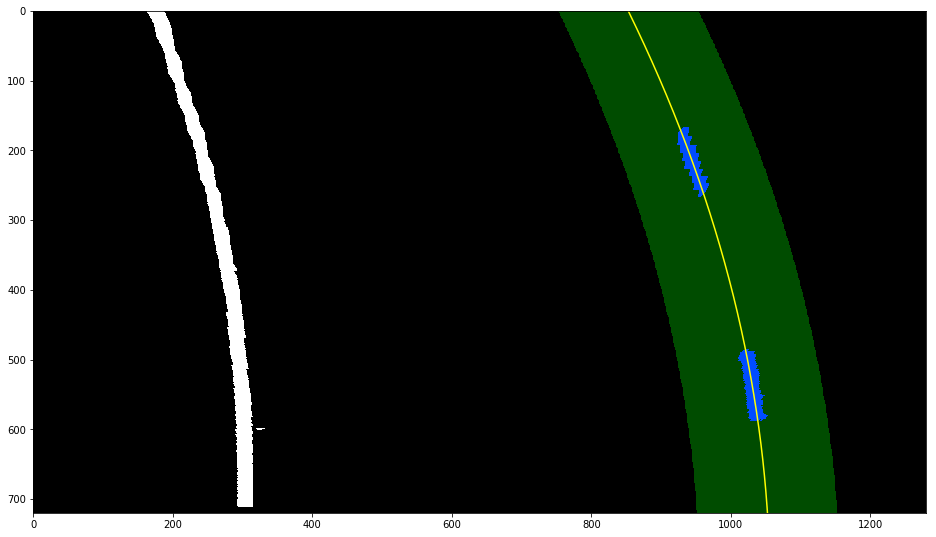

In [13]:
# Pixel space
def search_around_poly(img, fit_prev):
    # Width of search window
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    lane_inds = ((nonzerox > (fit_prev[0]*(nonzeroy**2) + fit_prev[1]*nonzeroy + 
                    fit_prev[2] - margin)) & (nonzerox < (fit_prev[0]*(nonzeroy**2) + 
                    fit_prev[1]*nonzeroy + fit_prev[2] + margin)))

    # Again, extract left and right line pixel positions
    xpnts = nonzerox[lane_inds]
    ypnts = nonzeroy[lane_inds] 

    # Fit new polynomials
    fit_new, s = fit_polynomial(xpnts, ypnts)
    
    return fit_new, xpnts, ypnts, s
    

# Function inteded only for plotting search window
def plot_srch_poly(img, fit_prev, fit_new, xpnts, ypnts, color=(0,0,255)):
    
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fitx_prev = eval_poly(fit_prev, ploty)
    line_window1 = np.array([np.transpose(np.vstack([fitx_prev-margin, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx_prev+margin, ploty])))])
    line_pts = np.hstack((line_window1, line_window2))

    out_img[ypnts, xpnts] = color
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.figure(figsize=(16,10))
    plt.imshow(result)
    plt.plot(eval_poly(fit_new, ploty), ploty, color='yellow')



left_fit_new, leftx, lefty, s = search_around_poly(warp_imgs[test_idx], left_fit)
right_fit_new, rightx, righty, s = search_around_poly(warp_imgs[test_idx], right_fit)

plot_srch_poly(thisImg, left_fit, left_fit_new, leftx, lefty, (255,0,0))
plot_srch_poly(thisImg, right_fit, right_fit_new, rightx, righty)




# Calculate Curvature

In [14]:
# Calculate curvature in world space
def calc_curv(y_val, fit, mpx, mpy):
    # Convert fit polynomial from pixel space to world space
    fit_m = fit*[mpx/(mpy**2), mpx/mpy, mpx] #[3rd values don't matter because they don't get used...]
    curv = ((1 + (2*fit_m[0]*y_val + fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
    
    return curv

CURV_IDX = 0

l_curv = calc_curv(CURV_IDX, left_fit, MPX, MPY)
r_curv = calc_curv(CURV_IDX, right_fit, MPX, MPY)
print("Left: ", l_curv, "   Right: ", r_curv)

Left:  327.975293958    Right:  325.415749005


In [15]:
left_fit_test, s = fit_polynomial(leftx*MPX, lefty*MPY)

l_curv_test = calc_curv(0, left_fit_test, 1.0, 1.0)

print(l_curv_test)

327.975293958


# Plot Stuff

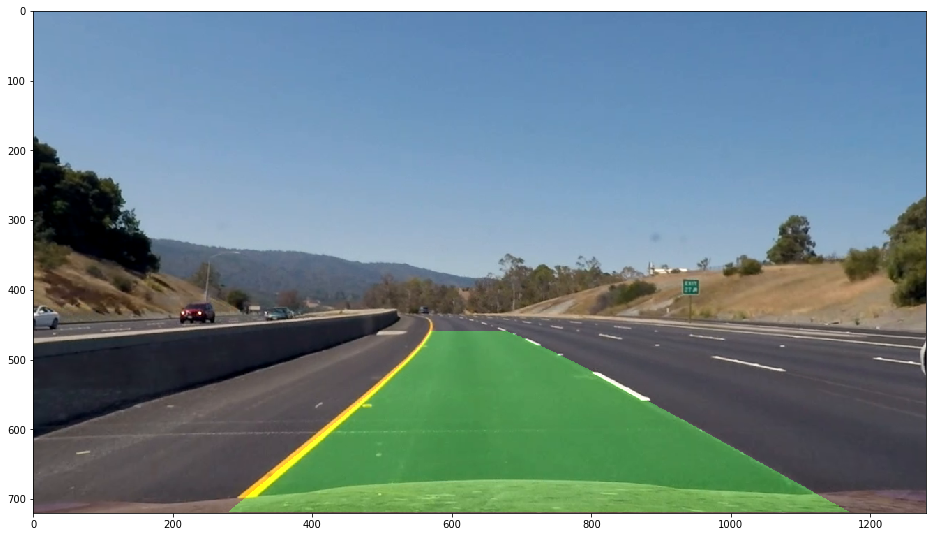

In [16]:
def plot_lane(undist_img, warped_img, M, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M, (undist_img.shape[1], undist_img.shape[0]), flags=cv2.WARP_INVERSE_MAP) 
    # Combine the result with the original image
    out_img = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return out_img


plt.figure(figsize=(16,20))
left_fitx = eval_poly(left_fit, ploty)
right_fitx = eval_poly(right_fit, ploty)
plt.imshow(plot_lane(undist_imgs[test_idx], warp_imgs[test_idx], WARP_MTRX, left_fitx, right_fitx, ploty))


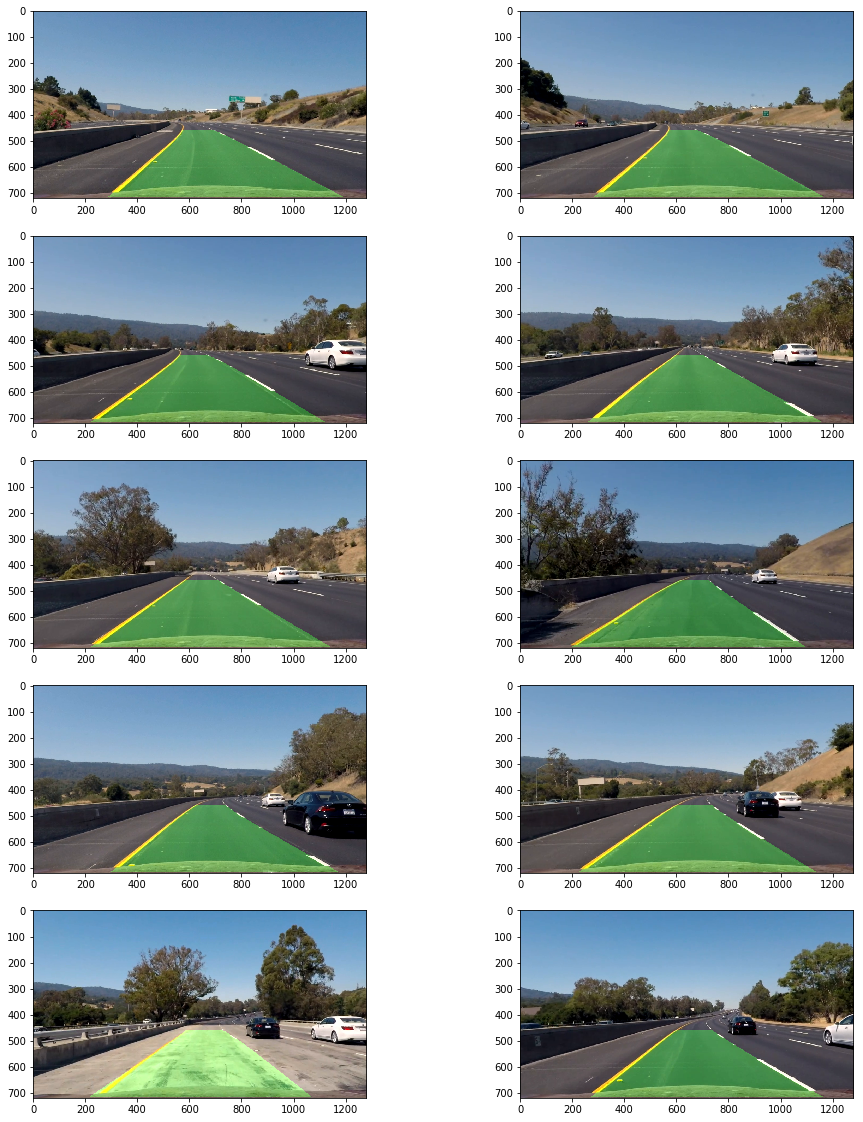

In [17]:
lane_imgs = []
for idx in range(len(warp_imgs)):
    leftx, lefty, left_conf, rightx, righty, right_conf, out_img = find_lane_pixels(warp_imgs[idx])
    left_fit, s = fit_polynomial(leftx, lefty)
    right_fit, s = fit_polynomial(rightx, righty)
    l_curv = calc_curv(150, left_fit, MPX, MPY)
    r_curv = calc_curv(150, right_fit, MPX, MPY)
    left_fitx = eval_poly(left_fit, ploty)
    right_fitx = eval_poly(right_fit, ploty)
    lane_imgs.append(plot_lane(undist_imgs[idx], warp_imgs[idx], WARP_MTRX, left_fitx, right_fitx, ploty))

plot_imgs(lane_imgs)

In [25]:
class Line():
    
    # length of historical info
    hist_buff_size = 5
    fit_change_rate = [0.001, 0.01, 0]
    fail_thresh = 5
    
    def __init__(self):
        # iteration counter
        self.iter = 0
        # was the line detected in the last iteration?
        self.detected = False
        # fail counter
        self.fail_cntr = 0
        # fail indicator - init to true because we have no fit
        self.fail = True
        # failure iterations
        self.fail_frames = []
        # confidence
        self.conf_this = None
        # confidence level of the last n fits of the line
        self.conf_hist = []
        # x values of the last n fits of the line
        self.x_hist = [] 
        #average x values of the fitted line over the last n iterations
        self.x_best = None     
        #polynomial coefficients averaged over the last n iterations
        self.fit_best = np.float32([0, 0, 0])  
        #polynomial coefficients for the most recent fit
        self.fit_this = np.float32([None])
        self.fit_hist = np.array([[0, 0, 0]])
        #radius of curvature of the line in some units
        self.curv = None
        #distance in meters of vehicle center from the line
        self.line_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
    
    # increment interation
    def iter(self):
        self.iter = self.iter+1
    
    def eval_poly(self, ypnts):
        fit = self.fit_best
        return fit[0]*ypnts**2 + fit[1]*ypnts + fit[2]
    
    
    def check_fit(self, fit):
        
        if(self.fit_this is not None):
            fit_diff = fit-self.fit_this #should be last best fit
            if(abs(fit_diff[0] > 0.1) | abs(fit_diff[1]>5.0) | abs(fit_diff[2]>100)):
                return False
            else:
                return True
        else:
            return True #if this is our first fit, we're forced to take it.
    
    
    def push_fit(self, fit):
        self.fit_this = np.array(fit)
        
        if(np.array_equal(self.fit_hist[0], np.float32([0,0,0]))):
            self.fit_hist = self.fit_this
            self.fit_hist = np.expand_dims(self.fit_hist, axis=0)
        else:
            self.fit_hist = np.append(self.fit_hist, [self.fit_this], axis=0)
                
        # if history buffer is full, remove first element
        if ((len(self.fit_hist) > self.hist_buff_size)):
            self.fit_hist = self.fit_hist[1:]
    
        self.fit_best[0] = np.sum(self.fit_hist[:,0])/np.float32(self.fit_hist[:,0].size)
        self.fit_best[1] = np.sum(self.fit_hist[:,1])/np.float32(self.fit_hist[:,1].size)
        self.fit_best[2] = np.sum(self.fit_hist[:,2])/np.float32(self.fit_hist[:,2].size)
        
        self.x_best = self.eval_poly(720)
        
        
    def report(self, success):
        if (success == True):
            self.fail_cntr = 0
        else:
            self.fail_cntr = self.fail_cntr+1
            self.fail_frames.append(self.iter)
        
    def failed(self):
        if (self.fail_cntr > self.fail_thresh):
            return True
        else:
            return False



class LaneInfo():
    hist_buff_size = 5
    curv_max = 10000 
    curv_RL = 100
    ofst_RL = 0.1
    width = 780
    
    def __init__(self):
        self.curv = None
        self.curv_prev = None
        self.curv_hist = []
        self.ofst= None
        self.ofst_prev = None
        self.ofst_hist = []
        
    def push_curv(self, curv):
        # first call
        if(self.curv_prev == None):
            self.curv_prev = curv
            
        self.curv_hist.append(curv)
        
        if(len(self.curv_hist) > self.hist_buff_size):
            self.curv_hist.pop(0)
        
        curv_raw = sum(self.curv_hist)/len(self.curv_hist)
        
        curv_RL = min(max(curv, self.curv_prev-self.curv_RL), self.curv_prev+self.curv_RL)
        self.curv = min(curv_RL, self.curv_max)
        self.curv_prev = self.curv
        
    def push_ofst(self, ofst):
        
        if(self.ofst_prev == None):
            self.ofst_prev = ofst
            
        self.ofst_hist.append(ofst)
        
        if(len(self.ofst_hist) > self.hist_buff_size):
            self.ofst_hist.pop(0)
            
        ofst_raw = sum(self.ofst_hist)/len(self.ofst_hist)
        
        self.ofst = min(max(ofst, self.ofst_prev-self.ofst_RL), self.ofst_prev+self.ofst_RL)
        self.ofst_prev = self.ofst
        

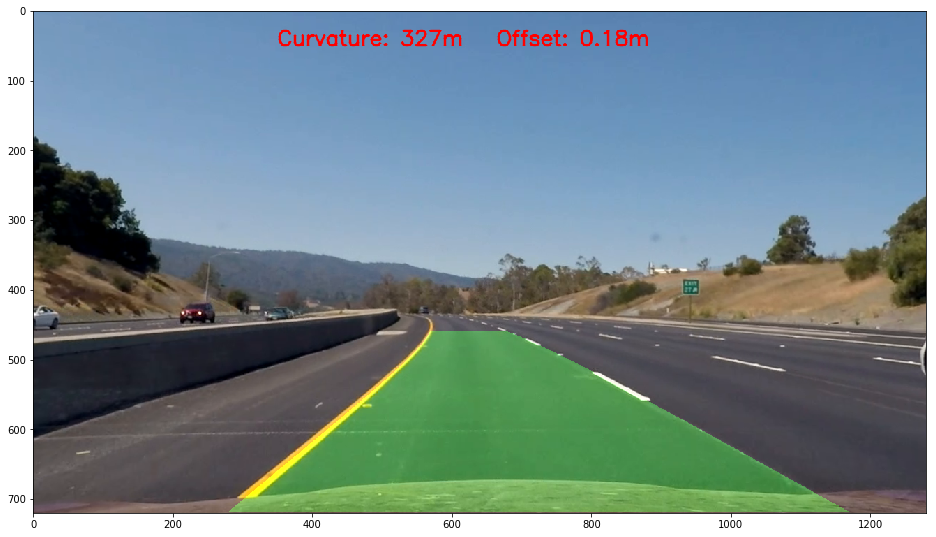

In [26]:
def proc_img(img, Lane, R, L):
    
    undist_img = undistort(img, UNDIST_MTRX, UNDIST_DIST)
    thresh_img = thresh_fcn(undist_img, plot=False)
    warp_img = warpPers(thresh_img, WARP_MTRX);
    img_cntr = img.shape[1]/2
    
    # Check to see if we've failed to find a fit in the last n attempts
    if((L.fail == True) | (R.fail == True)): # if so, run the full pixel search
        print("Running full pixel search.")
        L.allx, L.ally, L.conf_this, R.allx, R.ally, R.conf_this, out_img = find_lane_pixels(warp_img)
        L_fit, L_success = fit_polynomial(L.allx, L.ally)
        R_fit, R_success = fit_polynomial(R.allx, R.ally)

    else: # Otherwise, try fitting around previous polynomials
        L_fit, L.allx, L.ally, L_success = search_around_poly(warp_img, L.fit_this) # last best fit
        R_fit, R.allx, R.ally, R_success = search_around_poly(warp_img, R.fit_this) # last fit
        
        
    # Check for fit success
    if((L_success == True) & (R_success == True)): 

        # calculate curvature
        L_curv = calc_curv(CURV_IDX, L_fit, MPX, MPY)
        R_curv = calc_curv(CURV_IDX, R_fit, MPX, MPY)
        
        lane_width = eval_poly(R_fit, 720) - eval_poly(L_fit, 720)
        
        """
        print("Lane Width: ", lane_width*MPX)
        print("Curve diff: ", abs(L_curv-R_curv))
        print("Lane width diff:", abs(lane_width - Lane.width)*MPX)
        print("L fit: " , L.check_fit(L_fit))
        print("R fit: " , R.check_fit(R_fit))
        """
        
        if((abs(L_curv-R_curv)>0) &  # curvatures are close
            (abs(lane_width - Lane.width) < 150) &  # lane width is okay
            (L.check_fit(L_fit)) &  # L fit is good
            (R.check_fit(R_fit))): # R fit is good
           
            L.push_fit(L_fit)
            L.report(True)
            R.push_fit(R_fit)
            R.report(True)
            
            L.curv = L_curv
            R.curv = R_curv
            Lane.push_curv((L.curv + R.curv)/2.0)
            
            offset = (((L.x_best+R.x_best)/2.0)-img_cntr)*MPX
            Lane.push_ofst(offset)
            
        else:
            print("Failed sanity check")
            L.report(False)
            R.report(False)

    else: 
        print("Fit unsuccessful")
        L.report(False)
        R.report(False)

    if((L.fit_best is None) | (R.fit_best is None)):
        # we don't have a fit at all; plot the image
        return img
    
    else:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        img_for_text = plot_lane(undist_img, warp_img, WARP_MTRX, L.eval_poly(ploty), R.eval_poly(ploty), ploty)

        #Plot text
        text_font = cv2.FONT_HERSHEY_SIMPLEX
        text_scale = 1
        text_location = (350,50)
        text_color = (255,0,0)
        text_line = cv2.LINE_AA
        text_thickness = 2
        text_string = "Curvature: {0:.0f}m   Offset: {1:.2f}m".format(float(Lane.curv), float(Lane.ofst))
        
        cv2.putText(img_for_text, text_string , text_location, text_font, text_scale, text_color, text_thickness, text_line)

        return img_for_text

    # increments interations
    L.iter()
    R.iter()


Lane1 = LaneInfo()
R_Line1 = Line()
L_Line1 = Line()

img = proc_img(raw_imgs[test_idx], Lane1, R_Line1, L_Line1)
plt.figure(figsize = (16, 10))
plt.imshow(img)
img = proc_img(raw_imgs[test_idx], Lane1, R_Line1, L_Line1)


In [27]:
Lane2 = LaneInfo()
R_Line2 = Line()
L_Line2 = Line()
from IPython.display import HTML

output_file1 = 'output_images/output.mp4'
output_clip1 = clip1.fl_image(lambda image: proc_img(image, Lane2, R_Line2, L_Line2))#.subclip(19,26)
%time output_clip1.write_videofile(output_file1, audio=False)

[MoviePy] >>>> Building video output_images/output.mp4
[MoviePy] Writing video output_images/output.mp4


 49%|██████████████████████████████████████▌                                        | 616/1261 [01:38<01:42,  6.28it/s]

Failed sanity check


 49%|██████████████████████████████████████▋                                        | 617/1261 [01:38<01:42,  6.28it/s]

Failed sanity check


 49%|██████████████████████████████████████▋                                        | 618/1261 [01:38<01:42,  6.28it/s]

Failed sanity check


 49%|██████████████████████████████████████▊                                        | 619/1261 [01:38<01:42,  6.28it/s]

Failed sanity check


 49%|██████████████████████████████████████▊                                        | 620/1261 [01:38<01:42,  6.28it/s]

Failed sanity check


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:45<00:36,  6.25it/s]

Failed sanity check


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:46<00:35,  6.25it/s]

Failed sanity check


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:21<00:00,  6.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output.mp4 

Wall time: 3min 22s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))

In [33]:
Lane3 = LaneInfo()
L_Line3 = Line()
R_Line3 = Line()

clip2 = VideoFileClip('challenge_video.mp4')
output_file2 = 'output_images/challenge1.mp4'
output_clip2 = clip2.fl_image(lambda image: proc_img(image, Lane3, R_Line3, L_Line3)).subclip(0,3)
%time output_clip2.write_videofile(output_file2, audio=False)

Failed sanity check


TypeError: float() argument must be a string or a number, not 'NoneType'

In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file2))

In [ ]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.array([7, 8, 9])

d = np.append([a],[b], axis=0)

print(d)

print(d[:,0])